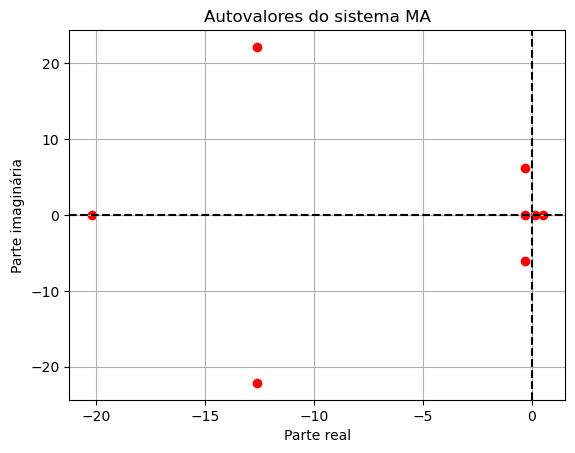

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import control as ctr
from ipywidgets import interact, FloatSlider

id_var = 1 # MUDAR PARA A VARIÁVEL DE INTERESSE NOS GRÁFICOS


## Constantes
g = 9.81 # m/s²
m = 2.4 # kg
u0 = 23.43245 # m/s
theta0 = 2.559*180/np.pi # rad, considerar theta
phi0 = 3*180/np.pi # rad

Ixx = 0.05598  # kgm²
Iyy = 0.04788  # kgm²
Izz = 0.10352  # kgm²
Ixz = -0.00211 # kgm²
Ixy = -0.0000075 # kgm²
Iyz = -0.0000002 # kgm²

## Funcoes
def dbeta_dp(Yp, Yr, Ybeta, Lp, Lr, Lbeta, Np, Nr, Nbeta): # Mudança de beta pela rolagem, provem de derivacao das eqs de lateral
    denominador = Ybeta + Yr * ((Lr * Nbeta - Lbeta * Nr) / (Lr * Np - Lp * Nr))
    numerador = Yp + Yr * ((Lp * Nbeta - Lbeta * Np) / (Lr * Np - Lp * Nr))
    resultado = -numerador / denominador
    return resultado

def dbeta_dr(Yp, Yr, Ybeta, Lp, Lr, Lbeta, Np, Nr, Nbeta): # Mudança de beta pela guinada, provem de derivacao das eqs de lateral
        numerador = (Np * Lr / Lp) - Nr
        denominador = Nbeta - (Np * Lbeta / Lp)      
        resultado = numerador / denominador
        return resultado

## Determinados do XFLR5
Xu=	-0.17604
Xalpha=	1.3633
Zu=	-1.9892
Zalpha=	-18.566
Zq=	-4.9505
Mu=	0.0010976
Malpha=	-1.1415
Mq=	-0.82869

	
Ybeta=	-0.32304
Yp=	-0.068839
Yr=	0.15623
Lbeta=	-0.3551
Lp=	-1.1237
Lr=	0.18423
Nbeta=	0.13096
Np=	-0.099993
Nr=	-0.045389


## Calculados por proxy
    
db_dp = dbeta_dp(Yp, Yr, Ybeta, Lp, Lr, Lbeta, Np, Nr, Nbeta)
db_dr = dbeta_dr(Yp, Yr, Ybeta, Lp, Lr, Lbeta, Np, Nr, Nbeta)
Xq = 0
Xbeta =  (2.220175-2.2207)/0.25 # dFx/dbeta, do XFLR5
Xp = Xbeta * db_dp # dCx/dbeta * dbeta_dp
Xr = Xbeta * db_dr

Zbeta = (23.30638-23.32382)/0.25
Zp = Zbeta*db_dp
Zr = Zbeta*db_dr

Mbeta = (-0.01431499 +0.000351469)/0.25
Mp = Mbeta * db_dp
Mr = Mbeta * db_dr

## Para o controle, estimados individualmente no XFLR5

# Subscrito δelevador
X_de=	-2.4249
Y_de=	0.0040723
Z_de=	-52.927
L_de=	-0.00034691
M_de=	-14.969
N_de=	-0.00087569


# Subscrito δrudder (leme)
X_dr =	 -96.58
Y_dr = 	-0.0022158
Z_dr =	 -384.27
L_dr = 	0.0012264
M_dr =	 -11.459
N_dr =	 -0.01483


# Subscrito δaileron
X_da=	-2.7749
Y_da=	0.00056597
Z_da=	-128.04
L_da=	-0.00005845
M_da=	-22.489
N_da=	0.000060727

# Matrizes intermediarias

F = np.array([
    [Xu / m, Xalpha / m, Xq / m, -g * np.cos(theta0) * np.cos(phi0), Xbeta / m, Xp / m, Xr / m, 0],
    [Zu / m, Zalpha / m, Zq/m + u0, g * np.sin(theta0) * np.cos(phi0),
     Zbeta / (m), Zp / (m), Zr / (m), g * np.sin(phi0)],
    [Mu, Malpha, Mq, 0, Mbeta, Mp, Mr, 0],
    [0, 0, np.cos(phi0), 0, 0, 0, -np.sin(phi0), 0],
    [0, 0, 0, 0, Ybeta / (m ), Yp / (m ), (Yr) / (m) - u0, g * np.cos(phi0) * np.cos(theta0)],
    [0, 0, 0, 0, Lbeta, Lp, Lr, 0],
    [0, 0, 0, 0, Nbeta, Np, Nr, 0],
    [0, 0, np.tan(theta0) * np.sin(phi0), 0, 0, 1, np.tan(theta0) * np.cos(phi0), 0]
])

E = np.array([
    [1, 0, 0, 0,  0,  0, 0, 0],
    [0, 1, 0, 0,  0,  0, 0, 0],
    [0, 0, Iyy, 0,  -Ixy,  -Iyz, 0, 0],
    [0, 0, 0, 1,  0,  0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, -Ixy, 0,  0, Ixx,  -Ixz, 0],
    [0, 0, Iyz, 0, 0, -Ixz,  Izz, 0],
    [0, 0, 0, 0,  0,   0,  0, 1]
])


G = np.array([
    [X_de/m, X_dr/m, X_da/m],
    [Z_de/(m*u0), Z_dr/(m*u0), Z_da/(m*u0)],
    [M_de, M_dr, M_da],
    [0, 0, 0],
    [Y_de/(m*u0), Y_dr/(m*u0), Y_da/(m*u0)],
    [L_de, L_dr, L_da],
    [N_de, N_dr, N_da],
    [0, 0, 0]
])

# Para o Espaço de Estados

A = np.linalg.inv(E) @ F
B = np.linalg.inv(E) @ G
C = np.eye(len(A))
D = np.zeros((A.shape[0], B.shape[1])) 


## Análise de estabilidade


eigenvalues = np.linalg.eigvals(A)

reais = np.real(eigenvalues)
imaginarias = np.imag(eigenvalues)

plt.figure()
plt.scatter(reais, imaginarias, color='red', marker='o')
plt.axhline(0, color='black', linewidth=1.5, linestyle='--')
plt.axvline(0, color='black', linewidth=1.5, linestyle='--')
plt.title('Autovalores do sistema MA')
plt.xlabel('Parte real')
plt.ylabel('Parte imaginária')
plt.grid()
plt.show()


## Para Controlabilidade e Observabilidade
# Q =  [B | AB | ... | A^n-1B]

Ct =np.hstack([np.linalg.matrix_power(A, n) @ B for n in range(1, len(A)-1)])
Ct = np.concatenate((B, Ct), 1)
rank_Ct = np.linalg.matrix_rank(Ct)

# Ob = [C | CA | ... | C^n-1A].T

Ob =np.vstack([np.linalg.matrix_power(C, n) @ A for n in range(1, len(A)-1)])
Ob = np.concatenate((C, Ob), 0)
rank_Ob = np.linalg.matrix_rank(Ob)


In [2]:

## LQR
# Ricatti Algébrica: A.t * P + P * A − P * B * R^−1 * B.t * P + Q = 0

nomes_x = ['$u$', '$\\alpha$', '$q$', '$\\theta$', '$\\beta$', '$p$', '$r$', '$\phi$']
nomes_u = ["$\delta_e$", "$\delta_r$", "$\delta_a$"]
x0 = 0.1*np.ones(8) 
t_span = (0, 20)
t_eval = np.linspace(0, 20, 500)
def MF_interativo_por_estado(A, B):
    QRKA = {}


    def interacao_qr(
        q0=1, q1=1, q2=1, q3=1, q4=1, q5=1, q6=1, q7=1,
        r0=1, r1=1, r2=1
    ):
        Q = np.diag([q0, q1, q2, q3, q4, q5, q6, q7])
        R = np.diag([r0, r1, r2])
        
        K, P, MF_eigenvalues = ctr.lqr(A, B, Q, R)
        A_bar = A - B @ K

        MF_reais = np.real(MF_eigenvalues)
        MF_imaginarias = np.imag(MF_eigenvalues)

        plt.figure()
        plt.scatter(-MF_reais, MF_imaginarias, color='red', marker='o')
        plt.axhline(0, color='black', linewidth=1.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=1.5, linestyle='--')
        plt.title('Autovalores do sistema em Malha Fechada')
        plt.xlabel('Parte real')
        plt.xscale('log')
        plt.xlim(1e-3, 1000)
        plt.ylim(-10, 10)
        plt.ylabel('Parte imaginária')
        plt.grid()
        plt.show()

        print("Autovalores MF:", MF_eigenvalues)

        QRKA['Q'] = Q
        QRKA['R'] = R
        QRKA['K'] = K
        QRKA['A_bar'] = A_bar
        QRKA['eig'] = MF_eigenvalues
        def espaco_estado(t, x, A, B, u):
            return A @ x + B @ u
    
        def calculo_ee(A, B, x0, t_span, t_eval):
            u = np.array([0, 0, 0])
        
            sol = solve_ivp(
                fun=lambda t, x: espaco_estado(t, x, A, B, u),
                t_span=t_span,
                y0=x0,
                t_eval=t_eval,
                method='RK45'
            )
        
            plt.figure(figsize=(10, 6))
            for i in range(8):
                plt.plot(sol.t, sol.y[i], label=nomes_x[i])
            plt.title('Estados')
            plt.xlabel('Tempo (s)')
            plt.ylabel('Estados')
            plt.ylim(-0.5, 0.5)
            plt.xlim(0, 10)
            plt.legend()
            plt.grid(True)
            plt.show()
        calculo_ee(A_bar, np.zeros(3), x0, t_span, t_eval)

        
    interact(
        interacao_qr,
        q0=FloatSlider(min=0.01, max=100, step=0.1, value=8, description='Q_u'),
        q1=FloatSlider(min=0.01, max=1000, step=0.1, value=120, description='Q_alpha'),
        q2=FloatSlider(min=0.01, max=50, step=0.01, value=0.01, description='Q_q'),
        q3=FloatSlider(min=0.01, max=5000, step=0.1, value=2000, description='Q_theta'),
        q4=FloatSlider(min=0.01, max=5000, step=0.1, value=2000, description='Q_beta'),
        q5=FloatSlider(min=0.01, max=100, step=0.1, value=0.01, description='Q_p'),
        q6=FloatSlider(min=0.01, max=100, step=0.1, value=0.01, description='Q_r'),
        q7=FloatSlider(min=0.01, max=1000, step=0.1, value=150, description='Q_phi'),
        r0=FloatSlider(min=0.01, max=3, step=0.01, value=0.08, description='R_elev'),
        r1=FloatSlider(min=0.01, max=3, step=0.01, value=0.1, description='R_lem'),
        r2=FloatSlider(min=0.01, max=3, step=0.01, value=0.01, description='R_ail'),
    )

    return QRKA

QRKA = MF_interativo_por_estado(A, B)


interactive(children=(FloatSlider(value=8.0, description='Q_u', min=0.01), FloatSlider(value=120.0, descriptio…

In [3]:
from scipy.signal import place_poles
import mplcursors

# Resposta de estados
def resposta_livre(A_sistema,  x0, t_span, t_eval, titulo, estados = ['$u$', '$\\alpha$', '$q$', '$\\theta$', '$\\beta$', '$p$', '$r$', '$\phi$']):
    sol = solve_ivp(
        lambda t, x: A_sistema @ x,
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        method='RK45'
    )

    plt.figure()
    for i in estados:
        pos_estado = nomes_x.index(i)
        plt.plot(sol.t, sol.y[pos_estado, :], label=i)
    plt.title(f'Resposta Livre dos Estados - {titulo}')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    mplcursors.cursor(hover=True)

    plt.show()

    return sol

def esforco_atuadores(solucao, K_ganho, titulo):
    U = -K_ganho @ solucao.y

    plt.figure(figsize=(10, 6))
    for i in range(U.shape[0]):
        plt.plot(solucao.t, U[i, :], label=nomes_u[i])
    plt.title(f'Esforço dos Atuadores - {titulo}')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Entrada de Controle')
    plt.grid(True)
    plt.legend()
    plt.show()

    pico_esforco = np.max(np.abs(U), axis=1)
    for i, pico in enumerate(pico_esforco):
        print(f'Pico {nomes_u[i]}: {pico:.2f}')

def diagrama_polos(A_sistema, titulo):
    autovalores = np.linalg.eigvals(A_sistema)
    plt.figure(figsize=(6, 6))
    plt.scatter(np.real(autovalores), np.imag(autovalores), color='red', marker='o')
    plt.axhline(0, color='black', linewidth=1.0, linestyle='--')
    plt.axvline(0, color='black', linewidth=1.0, linestyle='--')
    plt.title(f'Diagrama de Polos - {titulo}')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.grid(True)
    plt.show()



In [4]:
def simular_controlador(real1=-6.0, imag1=4.0, real2=-4.0, imag2=3.0,
                        r3=-8.0, r4=-5.0, r5=-3.0, r6=-1.5):

    polos = np.array([
        real1 + 1j * imag1,
        real1 - 1j * imag1,
        real2 + 1j * imag2,
        real2 - 1j * imag2,
        r3, r4, r5, r6  # restante reais
    ])

    try:
        alocacao = place_poles(A, B, polos)
    except Exception as e:
        print(f"Erro ao alocar polos: {e}")
        return

    K = alocacao.gain_matrix
    A_cl = A - B @ K
    diagrama_polos(A_cl, "Polos Alocados")
    sol = resposta_livre(A_cl, x0, t_span, t_eval, "Alocação de Polos", estados = ['$\\alpha$', '$\\beta$'])
    esforco_atuadores(sol, K, "Alocação de Polos")
    return(A_cl)

# Criação dos sliders
interact(
    simular_controlador,
    real1=FloatSlider(min=-25, max=-15, step=0.01, value=-20.5, description='Re 1'),
    imag1=FloatSlider(min=0, max=5, step=0.01, value=1.07, description='Im 1'),
    real2=FloatSlider(min=-10, max=-0.1, step=0.01, value=-3.84, description='Re 2'),
    imag2=FloatSlider(min=0, max=5, step=0.01, value=3.52, description='Im 2'),
    r3=FloatSlider(min=-10, max=-0.1, step=0.01, value=-8.83, description='Real 3'),
    r4=FloatSlider(min=-10, max=-0.1, step=0.01, value=-1.53, description='Real 4'),
    r5=FloatSlider(min=-10, max=-0.1, step=0.01, value=-1.3, description='Real 5'),
    r6=FloatSlider(min=-10, max=-0.1, step=0.01, value=-1.25, description='Real 6'),
)


interactive(children=(FloatSlider(value=-20.5, description='Re 1', max=-15.0, min=-25.0, step=0.01), FloatSlid…

<function __main__.simular_controlador(real1=-6.0, imag1=4.0, real2=-4.0, imag2=3.0, r3=-8.0, r4=-5.0, r5=-3.0, r6=-1.5)>